**Set environment**

In [1]:
suppressMessages(suppressWarnings(source("../config/config_sing.R")))
show_env()

You are in Singularity: singularity_proj_encode_fcc 
BASE DIRECTORY (FD_BASE): /data/reddylab/Kuei 
WORK DIRECTORY (FD_WORK): /data/reddylab/Kuei/out 
CODE DIRECTORY (FD_CODE): /data/reddylab/Kuei/code 
PATH OF PROJECT (FD_PRJ): /data/reddylab/Kuei/code/Proj_CombEffect_ENCODE_FCC 
PATH OF RESULTS (FD_RES): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc 
PATH OF LOG     (FD_LOG): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc/log 


## Import data

In [2]:
fdiry = file.path(FD_RES, "results", "region", "annotation_ccres")
fname = "description.tsv"
fpath = file.path(fdiry, fname)

dat = read_tsv(fpath, show_col_types = FALSE)
vec = dat$Name

vec_txt_cnames1 = vec
IRdisplay::display(dat)

Name,Description
<chr>,<chr>
Chrom,Chromosome
Start,Start position
End,End position
Name,Name
Score,Score
Strand,[+-.]; Use '.' if no strand is assigned.
ThickStart,The starting position at which the feature is drawn thickly
ThickEnd,The ending position at which the feature is drawn thickly
ItemRgb,"An RGB value of the form R,G,B (e.g. 255,0,0)"


In [3]:
vec_txt_cnames2 = c(
    "Chrom_Guide", "Start_Guide", "End_Guide", 
    "Guide_ID", "Score"
)

In [4]:
ASSAY   = "CRISPRi_Growth_K562_Gersbach"
FOLDER  = "coverage_ccres_v4"

fdiry = file.path(FD_RES, "results", ASSAY, FOLDER)
fname = "CRISPRi_rAVG_log2FC_2.bed.gz"
fpath = file.path(fdiry, fname)

vec1 = vec_txt_cnames1
vec1 = vec_txt_cnames1
vec1 = paste0(vec1, "_A")

vec2 = vec_txt_cnames2
#vec2 = paste0(vec2, "_B")
vec_txt_cnames = c(vec1, vec2, "Overlap")

dat = read_tsv(fpath, col_names = vec_txt_cnames, show_col_types = FALSE)

dat_peak_score_import = dat
print(dim(dat))
head(dat)

[1] 885681     17


Chrom_A,Start_A,End_A,Name_A,Score_A,Strand_A,ThickStart_A,ThickEnd_A,ItemRgb_A,Category_A,Note_A,Chrom_Guide,Start_Guide,End_Guide,Guide_ID,Score,Overlap
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
chr1,605330,605668,EH38E2776534,0,.,605330,605668,"190,40,229",CA-TF,All-data/Full-classification,chr1,605580,605581,id-1,-0.180660,1
chr1,605330,605668,EH38E2776534,0,.,605330,605668,"190,40,229",CA-TF,All-data/Full-classification,chr1,605581,605582,id-2,0.486646,1
chr1,605330,605668,EH38E2776534,0,.,605330,605668,"190,40,229",CA-TF,All-data/Full-classification,chr1,605589,605590,id-3,3.171240,1
chr1,605330,605668,EH38E2776534,0,.,605330,605668,"190,40,229",CA-TF,All-data/Full-classification,chr1,605591,605592,id-4,-0.364573,1
chr1,605330,605668,EH38E2776534,0,.,605330,605668,"190,40,229",CA-TF,All-data/Full-classification,chr1,605592,605593,id-5,-0.206319,1
chr1,605330,605668,EH38E2776534,0,.,605330,605668,"190,40,229",CA-TF,All-data/Full-classification,chr1,605609,605610,id-6,-0.266750,1


## Arrange

In [5]:
dat = dat_peak_score_import
dat = dat %>% 
    dplyr::mutate(
        Chrom  = Chrom_A,
        Start  = Start_A,
        End    = End_A,
        Region = paste0(Chrom_A, ":", Start_A, "-", End_A),
        Index  = Name_A,
        Label  = Category_A,
        Score  = Score
    ) %>%
    dplyr::select(
        Chrom, Start, End, Region, Index, Label, Score
    )

###
dat_peak_score_arrange = dat
print(dim(dat))
head(dat)

[1] 885681      7


Chrom,Start,End,Region,Index,Label,Score
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
chr1,605330,605668,chr1:605330-605668,EH38E2776534,CA-TF,-0.180660
chr1,605330,605668,chr1:605330-605668,EH38E2776534,CA-TF,0.486646
chr1,605330,605668,chr1:605330-605668,EH38E2776534,CA-TF,3.171240
chr1,605330,605668,chr1:605330-605668,EH38E2776534,CA-TF,-0.364573
chr1,605330,605668,chr1:605330-605668,EH38E2776534,CA-TF,-0.206319
chr1,605330,605668,chr1:605330-605668,EH38E2776534,CA-TF,-0.266750


## Summary

In [6]:
###
dat = dat_peak_score_arrange
dat = dat %>% dplyr::mutate(Sign  = ifelse(Score > 0, "pos", "neg"))
table(dat$Sign)


   neg    pos 
462342 423339 

In [7]:
###
dat = dat_peak_score_arrange
dat = dat %>% dplyr::mutate(Sign  = ifelse(Score > 0, "pos", "neg"))

###
dat_summary_total = dat %>%
    dplyr::group_by(Region) %>%
    dplyr::summarise(
        Mean    = mean(Score),
        Median  = median(Score),
        Max     = max(Score),
        Min     = min(Score),
        Count   = n(),
        .groups = "drop"
    )

###
dat_summary_sign = dat %>%
    dplyr::group_by(Region, Sign) %>%
    dplyr::summarise(Mean = mean(Score), .groups = "drop") %>% 
    dplyr::mutate(Sign = dplyr::recode(Sign, `pos` = "Mean_Pos", `neg` = "Mean_Neg")) %>% 
    tidyr::spread(Sign, Mean)

###
dat = dplyr::left_join(
    dat_summary_total,
    dat_summary_sign,
    by = c("Region")) %>% 
    replace(is.na(.), 0)

dat_peak_score_summary = dat
print(dim(dat))
head(dat)

[1] 152808      8


Region,Mean,Median,Max,Min,Count,Mean_Neg,Mean_Pos
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
chr10:100006302-100006644,0.3432904,0.3756255,1.490990,-0.606268,10,-0.4285530,0.6740804
chr10:100009359-100009597,-0.0594750,-0.0594750,-0.059475,-0.059475,1,-0.0594750,0.0000000
chr10:100009615-100009781,0.4072320,0.4072320,0.526902,0.287562,2,0.0000000,0.4072320
chr10:100009828-100010178,-0.1293382,-0.1194500,0.484747,-0.655965,5,-0.4172263,0.3024940
chr10:100010237-100010448,-0.6092790,-0.6092790,-0.609279,-0.609279,1,-0.6092790,0.0000000
chr10:100046073-100046363,0.1087357,0.1820295,0.646953,-0.497578,10,-0.2750008,0.3645600


In [8]:
dat = dat_peak_score_summary
summary(dat$Count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   3.000   6.000   5.796   9.000  20.000 

In [9]:
dat = dat_peak_score_summary
table(dat$Count)


    1     2     3     4     5     6     7     8     9    10    11    12    13 
20699 16295 13607 11921 10898 10155  9983 10213 13885 35035    36    26    16 
   14    15    16    17    18    19    20 
    6     9     7     2     3     8     4 

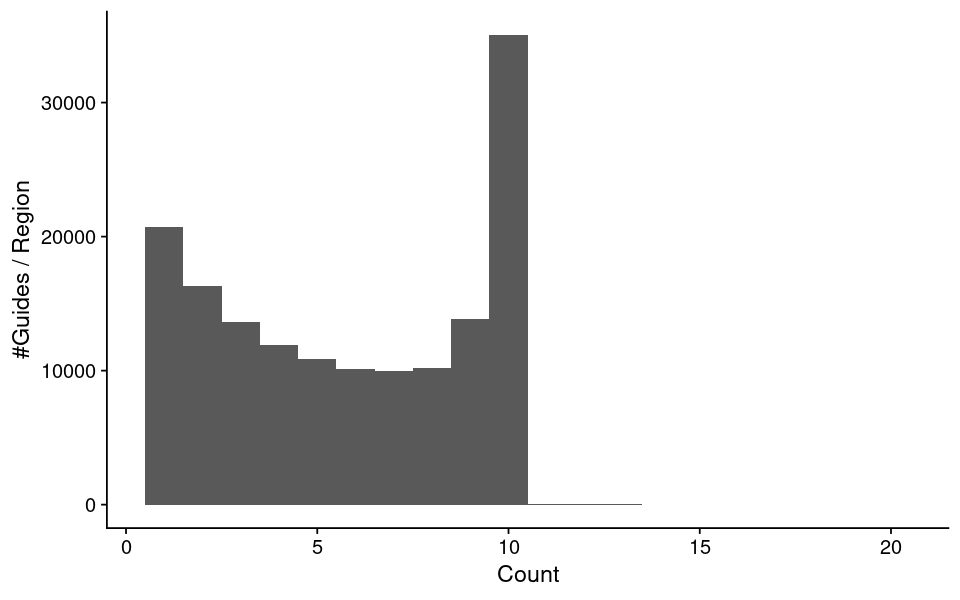

In [10]:
dat = dat_peak_score_summary
gpt = ggplot(dat, aes(x=Count)) + 
    geom_histogram(binwidth = 1) + 
    labs(y="#Guides / Region") +
    theme_cowplot()
options(repr.plot.height=5, repr.plot.width=8)
print(gpt)

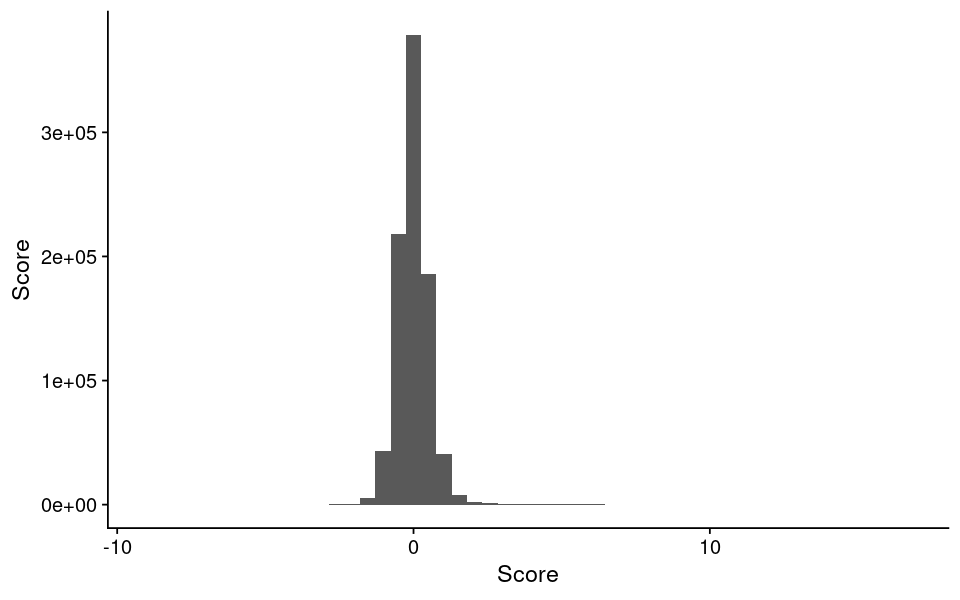

In [11]:
dat = dat_peak_score_arrange
gpt = ggplot(dat, aes(x=Score)) + 
    geom_histogram(bins = 50) + 
    labs(y="Score") +
    theme_cowplot()
print(gpt)

## Save results

In [14]:
ASSAY

[1] "CRISPRi_Growth_K562_Gersbach"

In [15]:
FOLDER

[1] "coverage_ccres_v4"

In [17]:
fdiry = file.path(FD_RES, "results", ASSAY, FOLDER, "summary")
fname = "results.score.tsv"
fpath = file.path(fdiry, fname)

dat = dat_peak_score_arrange
write_tsv(dat, fpath)

In [18]:
fdiry = file.path(FD_RES, "results", ASSAY, FOLDER, "summary")
fname = "results.summary.tsv"
fpath = file.path(fdiry, fname)

dat = dat_peak_score_summary
write_tsv(dat, fpath)